# Project Update

In [2]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

#  Exploring Data

In [4]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
print("The training set has {} rows and {} columns.".format(data.shape[0], data.shape[1]))

The training set has 7613 rows and 5 columns.


In [6]:
print("The training set has {} duplicated rows.".format(data.drop('id',axis=1).duplicated(keep=False).sum()))

The training set has 87 duplicated rows.


In [7]:
data[(data.drop(['id', 'target'], axis=1).duplicated(keep=False)) & ~(data.drop(['id'], axis=1).duplicated(keep=False))]

,id,keyword,location,text,target
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people...,0
3985,5662,floods,NaN,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after Ameri...,1
4232,6012,hazardous,NaN,Caution: breathing may be hazardous to your health.,1
4235,6017,hazardous,NaN,Caution: breathing may be hazardous to your health.,0
4305,6112,hellfire,NaN,Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #After...,1
4379,6220,hijacker,worldwide,RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG,0
4381,6223,hijacker,worldwide,RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG,1
4618,6566,injury,NaN,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,0
5620,8018,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,1
5641,8044,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,0


In [8]:
data[data.text.str.contains('CLEARED:incident with injury:I-495')]

,id,keyword,location,text,target
4597,6537,injury,NaN,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1
4605,6548,injury,NaN,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1
4618,6566,injury,NaN,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,0


# Analysis

-   The training dataset has 87 duplicate rows
-   The training dataset contains mislabellings.
-   The target column on similar tweets has different labels (1 and 0).
-   We are not able to relabel the tweets since we do not know which ones are correctly labelled and which ones are not.
-   It could be that the people who were labeling these tweets had different opinions about them being real or fake.
-   These tweets may have a negative impact on our overall model analysis.
-   The same mislabellings were done in the test data.

In [9]:
data[(data['text'].duplicated(keep=False)) & ~(data.drop(['id','target'], axis=1).duplicated(keep=False))].sort_values(by="text")[10:20]


,id,keyword,location,text,target
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous ...,0
4221,5996,hazardous,NaN,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous ...,1
7097,10169,violent%20storm,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://...,1
7034,10080,typhoon,REPUBLICA DOMINICANA,(#LosDelSonido) Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster decl...,1
2719,3905,devastated,REPUBLICA DOMINICANA,(#LosDelSonido) Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster decl...,1
3610,5153,fatal,Dimapur,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...,1
3604,5145,fatal,Bangalore,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...,1
3591,5130,fatal,Thane,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...,1
3589,5127,fatal,Varanasi,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...,1


In [10]:
print("There are {} tweets with same content but different locations.".format(data[(data['text'].duplicated(keep=False)) & ~(data.drop(['id','target'], axis=1).duplicated(keep=False))].shape[0]))

There are 82 tweets with same content but different locations.


# Tweets locations


-   There some tweets with same content but different locations/keywords.
-   The difference in keywords might be a labelling error however,
-   The difference in locations may be due to retweets. One tweet may be retweeted many times by people from different locations.
-   Nothing much can be done on this; only small fraction of tweets are affected.
-   Keyword and location features have missing values equal to 0.8% and 33.3% respectively.
-   The missing location values may be due to the user not allowing Twitter to access their location and hence the location could not be extracted during data tweets collection.

# Exclusion of Keyword and Location features

### 25 most common used keywords in the dataset

## Keyword

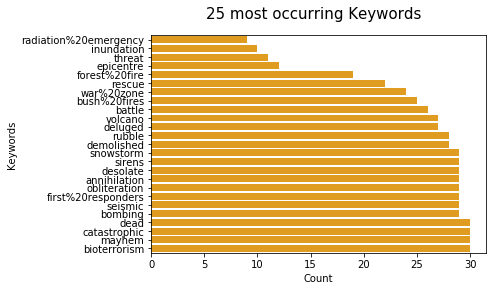

In [17]:
keyword = data[['keyword', 'target']].groupby('keyword')['target'].agg(frequencies= 'mean', count = 'size').reset_index().sort_values(by='count', ascending=True)

sns.barplot(y='keyword', x='count', data=keyword.iloc[:25], color='orange')
plt.gca().set_xlabel('Count')
plt.gca().set_ylabel('Keywords')
plt.suptitle("25 most occurring Keywords", size=15)
plt.show()

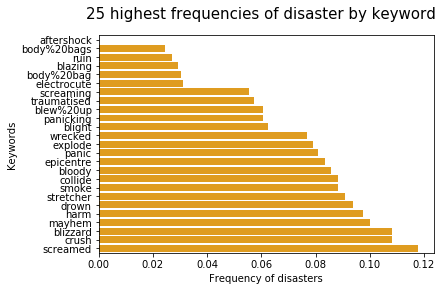

In [15]:
keyword.sort_values(by='frequencies', ascending=True, inplace=True)
sns.barplot(y='keyword', x='frequencies', data=keyword.iloc[:25], color='orange')
plt.gca().set_xlabel('Frequency of disasters')
plt.gca().set_ylabel('Keywords')
plt.suptitle("25 highest frequencies of disaster by keyword", size=15)
plt.show()

-   Word occurences in real or fake disaster tweets would not accurately reveal the impact of particular keyword in classification.
-   A keyword may appear many times both in real or fake disaster tweets. 
-   A keyword may also appear fewer in times both two categories.
-   Hence, its cumbersome to calculate the impact and influence of a keyword from its number of occurences.
-   Rather, computing the frequency of tweets relating disasters amongh those having a particular keyword is more efficient. 
-  The results may be deceiving.
-  A frequency of disaster equaling to 100% for a keyword that appeared once in a row is a possibility.
-  So, the reliability of the results would depend of the number of times each keyword appeard in the training dataset.
-  After some analysis, 20 keywords associated with the highest frequencies of disaster occurred between 29 and 40 times with an average of 34.8.
-  115 rows had keywords 'debris', 'wreckage', or 'derailment'.
-  The 20 keywords associated with the lowest frequencies of disaster occured between 12 and 41 times with an average of 33.7.
-  But since the keyword also appears in the text tweet, the keyword column(feature) can be dropped.

## Location

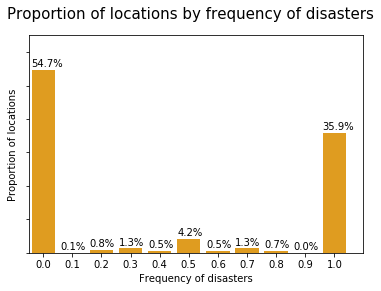

In [18]:
location = data[['location', 'target']].groupby('location')['target'].agg(frequencies= 'mean', count = 'size').reset_index().sort_values(by='frequencies', ascending=True)
x_value = location.frequencies.apply(lambda x:np.round(x,1)).value_counts().index
y_value = location.frequencies.apply(lambda x:np.round(x,1)).value_counts()
y_value = y_value/np.sum(y_value)
y_value*=100

sns.barplot(x=x_value, y=y_value, color='orange')
plt.gca().set_xlabel('Frequency of disasters')
plt.gca().set_ylabel('Proportion of locations')
plt.gca().set_yticklabels([])
plt.gca().set_xbound(-0.5, 11)
plt.gca().set_ybound(0, 65)

for i in range(11):
  plt.annotate(str(round(y_value.loc[i/10], 1))+'%', xy=(i-0.4,y_value.loc[i/10]+1), size=10)

plt.suptitle("Proportion of locations by frequency of disasters", size=15)
plt.show()

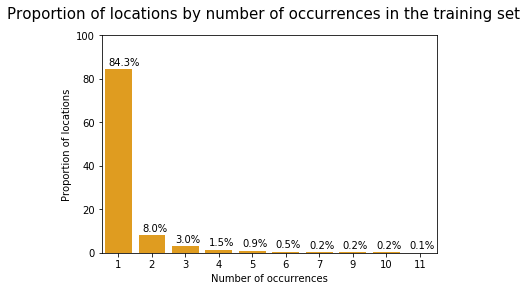

In [20]:
x_value = location['count'].value_counts()[:10].index
y_value = location['count'].value_counts().to_numpy()
y_value = y_value[:10]/np.sum(y_value)
y_value *= 100

sns.barplot(x=x_value, y=y_value, color='orange')
plt.gca().set_ylim([0, 100])
plt.gca().set_xlabel('Number of occurrences')
plt.gca().set_ylabel('Proportion of locations')

for i in range(10):
  plt.annotate(str(round(y_value[i], 1))+'%', xy=(i-0.3,y_value[i]+2), size=10)

plt.suptitle("Proportion of locations by number of occurrences in the training set", size=15)
plt.show()


In [21]:
location[location['count']>=20]

,location,frequencies,count
1826,New York,0.225352,71
1373,Kenya,0.250000,20
1534,"Los Angeles, CA",0.307692,26
1506,London,0.355556,45
587,Canada,0.448276,29
2662,United States,0.540000,50
2632,UK,0.592593,27
2643,USA,0.644231,104
2778,"Washington, DC",0.714286,21
1860,Nigeria,0.785714,28


## Analysis

 -  In actual fact, one could argue that all the tweets are associated with a particular location (whether disaster or not).
-   Most of the locations occur once in the training dataset.
-   The link between the location and the frequency of disaster is not clear.
-   For instance, the location 'New York City' occurs to times and is labeled as a disaster with frequency 60%.
-   Location 'New York, NY' appears 15 times and have a frequency of disaster equal to 47%. 
-   Location 'New York' appears in 71 tweets and 23% of those are about real disasters.
-   Location 'NYC' appears 12 times and have a frequency of disaster equals to 17%.
-   From this information, it is clear that there is a huge variability of the link between a location and its frequency of disaster.
-   However, there are few locations with reliable indications. This include 'USA' which appears 104 times and has 64% of its tweets being disasters. 
-   One can argue that the meaningfulness of the frequency of disasters relies upon the substantial amount of tweets characterizing a particular location. 
-   Unfortunately, most locations appear only once and thus would not give a good indication about a tweet being real or fake.